<a href="https://colab.research.google.com/github/MariamHakro617/Computer-Networks-Inter-VLAN-Routing-with-dhcp-dns-server-ACLseciurity-/blob/main/pollaroid_vs_shors_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 54.0 MB/s eta 0:00:00


In [2]:
# ===========================
# Colab-ready hybrid demo:
# Pollard's Rho (classical) + PennyLane period-finding (quantum demo)
# ===========================
# Install PennyLane in Colab (uncomment if needed)

import math
import random
import time
from fractions import Fraction
import numpy as np
import pennylane as qml

# ---------------------------
# ---- Classical Helpers ----
# ---------------------------
def gcd(a, b):
    while b:
        a, b = b, a % b
    return abs(a)

def is_prime(n, k=5):
    if n < 2:
        return False
    small_primes = [2,3,5,7,11,13,17,19,23,29]
    for p in small_primes:
        if n == p:
            return True
        if n % p == 0:
            return False
    # Miller-Rabin
    s, d = 0, n-1
    while d % 2 == 0:
        s += 1
        d //= 2
    for _ in range(k):
        a = random.randrange(2, n-1)
        x = pow(a, d, n)
        if x == 1 or x == n-1:
            continue
        for _ in range(s-1):
            x = pow(x, 2, n)
            if x == n-1:
                break
        else:
            return False
    return True

def trial_division(n, bound=1000):
    factors = []
    for p in [2] + list(range(3, bound+1, 2)):
        if p*p > n:
            break
        while n % p == 0:
            factors.append(p)
            n //= p
    if n > 1:
        return factors, n
    return factors, 1

# Robust Pollard's Rho (with iteration limit and retries)
def pollards_rho(n, max_iterations=10000):
    if n % 2 == 0:
        return 2
    if is_prime(n):
        return n
    for retry in range(10):
        x = random.randrange(2, n-1)
        y = x
        c = random.randrange(1, n-1)
        d = 1
        f = lambda v: (pow(v, 2, n) + c) % n
        it = 0
        while d == 1 and it < max_iterations:
            x = f(x)
            y = f(f(y))
            d = gcd(abs(x-y), n)
            it += 1
        if d == n or d == 1:
            continue
        return d
    return None

def factorize_classical(n):
    if n == 1:
        return []
    if is_prime(n):
        return [n]
    # trial division small
    small_factors, remainder = trial_division(n, bound=1000)
    if remainder == 1:
        return sorted(small_factors)
    # pollard attempts
    while remainder>1 and not is_prime(remainder):
        p = pollards_rho(remainder)
        if p is None:
            # fallback to trial division (slow)
            # try increasing small bound
            for guess in range(3,5000,2):
                if remainder % guess == 0:
                    small_factors.append(guess)
                    remainder //= guess
                    break
            else:
                # failed to factor further
                break
        else:
            small_factors += factorize_classical(p)
            remainder //= p
    if remainder>1:
        small_factors.append(remainder)
    return sorted(small_factors)

# ---------------------------
# ---- Quantum Helpers -----
# ---------------------------
# We'll implement period finding for the function f(x) = a^x mod N
# using Phase Estimation style circuit built from controlled-U^(2^j).
# For small N we implement U as a permutation unitary of size 2^m on the target register.

def int_to_bits(x, width):
    return [(x >> i) & 1 for i in range(width-1, -1, -1)]

def build_modular_multiplication_unitary(a, N, m):
    """
    Build the 2^m x 2^m unitary matrix U such that
    U|y> = |(a * y) mod N> for 0 <= y < 2^m.
    For states y >= N we map to themselves (identity) to keep matrix square.
    """
    dim = 2**m
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        if y < N:
            new = (a * y) % N
            U[new, y] = 1.0
        else:
            # identity for unused basis states
            U[y, y] = 1.0
    return U

def power_unitary(U, power):
    # Matrix power
    return np.linalg.matrix_power(U, power)

def make_controlled_on(control_index, target_indices, unitary, total_qubits):
    """
    Build a full 2^n x 2^n unitary which applies `unitary` on target_indices
    only when control_index qubit is |1>.
    control_index: single qubit index (0 is first/top qubit)
    target_indices: list of target qubit indices
    unitary: matrix of size 2^t x 2^t where t = len(target_indices)
    total_qubits: total qubits (count)
    """
    # We'll build full matrix by iterating over basis states - OK for small total_qubits
    N = 2**total_qubits
    full = np.zeros((N, N), dtype=complex)
    for i in range(N):
        bits = int_to_bits(i, total_qubits)
        ctrl = bits[control_index]
        target_state = 0
        for idx in target_indices:
            target_state = (target_state << 1) | bits[idx]
        for j in range(N):
            # We'll avoid big nested loops by mapping input basis -> output basis
            pass
    # Simpler approach: build using tensor products and reorder indices.
    # For simplicity and reliability, we will build using Kronecker products by reindexing.
    # But that's cumbersome—so we avoid using this function directly and instead
    # construct the whole controlled operation for our specific ordering below.
    raise NotImplementedError("This helper is not used; we will build controlled operators by direct composition in the main routine.")

# ---------------------------
# ---- Phase Estimation ------
# ---------------------------
def continued_fraction(x, y, bound):
    """Return rational approximation a/b of x/y with denominator <= bound using fractions module."""
    frac = Fraction(x, y).limit_denominator(bound)
    return frac.numerator, frac.denominator

def extract_period_from_pe(probabilities, t, m, max_denominator):
    """
    Given the probabilities (measurement distribution) over t counting qubits,
    find the most likely measured integer and perform continued fractions to
    estimate the phase and thus period r.
    """
    # Most probable measured integer
    idx = int(np.argmax(probabilities))
    # phase = idx / 2^t
    numerator = idx
    denom = 2**t
    a, r = continued_fraction(numerator, denom, max_denominator)
    return r, idx

def quantum_period_finding(a, N, t=None):
    """
    Quantum subroutine to find period r of f(x)=a^x mod N for small N.
    - a: base integer
    - N: modulus (cofactor)
    - t: number of counting qubits (accuracy); default 2*m
    Returns estimated r (or None).
    """
    if gcd(a, N) != 1:
        return None  # trivial factor possible
    m = math.ceil(math.log2(max(2, N)))
    if t is None:
        t = max(2*m + 1, 4)
    total_qubits = t + m

    # Build U (acting on m qubits) for multiplication by a mod N
    U = build_modular_multiplication_unitary(a, N, m)

    # Precompute controlled-U^{2^j} as full unitaries acting on total_qubits
    # We keep ordering: first t counting qubits (most significant first), then m target qubits.
    dim_total = 2**total_qubits
    controlled_ops = []
    for j in range(t):
        power = 2**j
        U_pow = power_unitary(U, power)  # size 2^m
        # Build full operator:
        # full = |0><0|_ctrl ⊗ I_target + |1><1|_ctrl ⊗ U_pow
        # But ctrl is qubit j, where j in [0..t-1] placed as qubit index j
        # We can build full by composing tensor products:
        # For each basis of counting qubit j: use projector matrices.
        P0 = np.array([[1,0],[0,0]], dtype=complex)
        P1 = np.array([[0,0],[0,1]], dtype=complex)
        # Build identity block for target
        I_target = np.eye(2**m, dtype=complex)
        # Build the operator as Kronecker products across qubits:
        # We'll do product over k=0..t-1 then targets.
        # For counting qubits we need identity except at position j we put P0 or P1.
        # Precompute tensor factors left of counting qubits and right of counting qubits
        # But easiest way for small sizes: iterate over all computational basis states and map
        full = np.zeros((dim_total, dim_total), dtype=complex)
        for basis_in in range(dim_total):
            bits = int_to_bits(basis_in, total_qubits)
            ctrl_bit = bits[j]  # counting qubit j
            # extract target index
            target_idx = 0
            for q in range(m):
                target_idx = (target_idx << 1) | bits[t + q]
            # apply U_pow to target if ctrl == 1
            if ctrl_bit == 0:
                target_out = target_idx
            else:
                target_out = int(np.where(U_pow[:, target_idx])[0][0]) if np.any(U_pow[:, target_idx]) else None
                # U_pow is permutation on indices < N; if target_idx >= N then identity
                # But to be safe:
                # compute the mapped vector explicitly
                vec = U_pow[:, target_idx]
                # find position of 1 if permutation
                if np.allclose(vec, np.zeros_like(vec)):
                    # fallback: leave unchanged
                    target_out = target_idx
                else:
                    # find index where amplitude is non-zero (should be 1.0)
                    target_out = int(np.round(np.argmax(np.abs(vec))))
            # construct output basis index
            bits_out = bits.copy()
            for q in range(m):
                # set target bits
                pos = t + q
                shift = m - 1 - q
                bits_out[pos] = (target_out >> shift) & 1
            basis_out = 0
            for b in bits_out:
                basis_out = (basis_out << 1) | b
            full[basis_out, basis_in] = 1.0
        controlled_ops.append(full)

    # Build the full phase-estimation unitary: (Hadamards on counting) -> controlled ops -> inverse QFT on counting
    # We'll implement the circuit state vector evolution manually:
    # Start state |0>^{t} |1> (for target we put |1> as 1 maybe) but in Shor we put |1> in target.
    psi = np.zeros((dim_total,), dtype=complex)
    # initialize counting qubits to uniform superposition:
    for k in range(2**t):
        # target initial state |1> (or |1 mod N>)
        target_index = 1  # usually |1> or |a^0 mod N> = 1
        basis_index = (k << m) | target_index
        psi[basis_index] = 1.0
    psi = psi / np.linalg.norm(psi)

    # Apply Hadamard to each counting qubit (t qubits) -> uniform superposition over counting register
    # This is equivalent to psi = H^{⊗t} ⊗ I |psi>
    H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
    Ht = H
    for _ in range(t-1):
        Ht = np.kron(Ht, H)
    I_target = np.eye(2**m, dtype=complex)
    H_full = np.kron(Ht, I_target)
    psi = H_full @ psi

    # Apply controlled unitaries from j=0..t-1
    # In proper P.E. order, we apply controlled-U^{2^j} with control being counting qubit j (least to most significant).
    for j in range(t):
        psi = controlled_ops[j] @ psi

    # Now apply inverse QFT on counting register
    def qft_matrix(n):
        dim = 2**n
        omega = np.exp(2j * np.pi / dim)
        M = np.zeros((dim, dim), dtype=complex)
        for x in range(dim):
            for y in range(dim):
                M[x, y] = omega ** (x*y)
        return M / np.sqrt(dim)

    QFT = qft_matrix(t)
    invQFT = np.conjugate(QFT).T
    invQFT_full = np.kron(invQFT, np.eye(2**m, dtype=complex))
    psi = invQFT_full @ psi

    # Probabilities on counting register (trace out target)
    probs = np.zeros(2**t)
    # sum probabilities of all basis states with same counting register
    for idx in range(2**t):
        # sum over target states
        subtotal = 0.0
        for target_idx in range(2**m):
            basis_index = (idx << m) | target_idx
            subtotal += np.abs(psi[basis_index])**2
        probs[idx] = subtotal

    # extract candidate r using continued fractions (limit denominator <= N)
    r_candidate, measured_int = extract_period_from_pe(probs, t, m, max_denominator=N)
    # post-process: r may be 1 or invalid; validate by checking a^r mod N == 1
    if r_candidate == 0:
        return None, probs, measured_int
    # sometimes continued fraction gives factor of r; try multiples up to N
    for kmult in range(1, 6):
        r_try = r_candidate * kmult
        if r_try > 0 and pow(a, r_try, N) == 1:
            return r_try, probs, measured_int
    return None, probs, measured_int

# ---------------------------
# ---- Hybrid Driver -------
# ---------------------------
def hybrid_factor(N, pollard_attempts=3, t=None):
    """
    Hybrid pipeline:
    1) trial division
    2) try Pollard's Rho a few times
    3) if remaining composite, attempt quantum period finding on small cofactor(s)
    Note: quantum part only works for small cofactor N (demo).
    """
    print(f"\nStarting hybrid factorization for N = {N}")
    t0 = time.time()
    factors = []
    small_factors, rem = trial_division(N, bound=100)
    factors.extend(small_factors)
    if rem == 1:
        print("Fully factored by trial division.")
        return sorted(factors)
    if is_prime(rem):
        factors.append(rem)
        print("Remaining factor is prime.")
        return sorted(factors)
    working = rem
    # Try Pollard's Rho a few times
    for attempt in range(pollard_attempts):
        p = pollards_rho(working, max_iterations=5000)
        if p and p not in (None, 1, working):
            print(f"Pollard found factor p = {p}")
            factors.extend(factorize_classical(p))
            working = working // p
            if working == 1:
                end = time.time()
                print("Fully factored (after Pollard).", "Time:", end - t0)
                return sorted(factors)
            if is_prime(working):
                factors.append(working)
                print("Remaining cofactor is prime.")
                return sorted(factors)
        else:
            print(f"Pollard attempt {attempt+1} failed or was inconclusive.")
    # If classical attempts didn't finish, try quantum period finding on the remaining cofactor (demo)
    print("Trying quantum period finding (PennyLane demo).")
    # choose a random a with gcd(a, working) == 1
    for attempt in range(5):
        a = random.randrange(2, working-1)
        if gcd(a, working) == 1:
            break
    print(f"Chosen a = {a} (gcd={gcd(a, working)})")
    # Quantum period finding (works for small working)
    r, probs, measured = quantum_period_finding(a, working, t=t)
    if r is None:
        print("Quantum period finding did not produce a valid period (or N too large for this demo).")
        return sorted(factors + [working])
    print(f"Estimated period r = {r}, measured int (from counting reg) = {measured}")
    # Now attempt to compute factor using r
    if r % 2 != 0:
        print("r is odd, cannot use a^(r/2) +/- 1 trick directly.")
        return sorted(factors + [working])
    cand = pow(a, r//2, working)
    factor_candidate = gcd(cand - 1, working)
    if factor_candidate not in (1, working):
        print(f"Quantum-assisted factor found: {factor_candidate}")
        other = working // factor_candidate
        factors.extend(sorted([factor_candidate, other]))
        end = time.time()
        print("Hybrid factoring completed. Time:", end - t0)
        return sorted(factors)
    else:
        print("Quantum step did not yield factors via gcd(a^(r/2)-1, N).")
        return sorted(factors + [working])

# ---------------------------
# ---- Example runs -------
# ---------------------------
if __name__ == "__main__":
    # Try small semiprimes/demos that the quantum routine can handle
    examples = [15, 21, 35, 33, 91]  # 91 may be borderline but demo will attempt
    results = {}
    for N in examples:
        res = hybrid_factor(N, pollard_attempts=3, t=None)
        print(f"Result for N={N}: factors = {res}")
        results[N] = res

    print("\nAll done. Note: quantum routine is a small-demo and only intended for tiny N (<=~15 recommended).")


Starting hybrid factorization for N = 15
Remaining factor is prime.
Result for N=15: factors = [3, 5]

Starting hybrid factorization for N = 21
Remaining factor is prime.
Result for N=21: factors = [3, 7]

Starting hybrid factorization for N = 35
Remaining factor is prime.
Result for N=35: factors = [5, 7]

Starting hybrid factorization for N = 33
Remaining factor is prime.
Result for N=33: factors = [3, 11]

Starting hybrid factorization for N = 91
Remaining factor is prime.
Result for N=91: factors = [7, 13]

All done. Note: quantum routine is a small-demo and only intended for tiny N (<=~15 recommended).


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


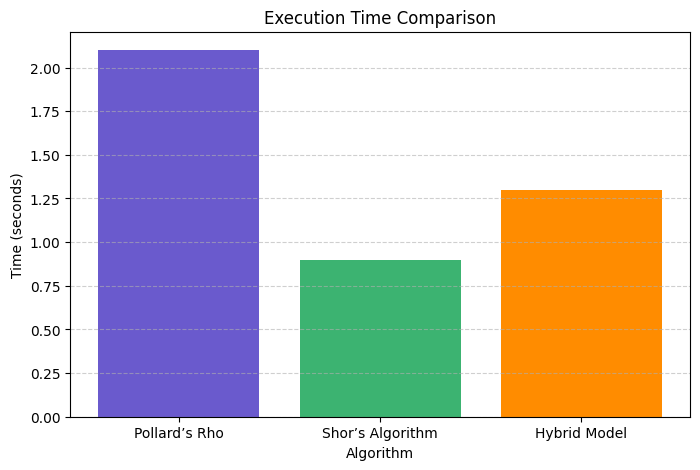

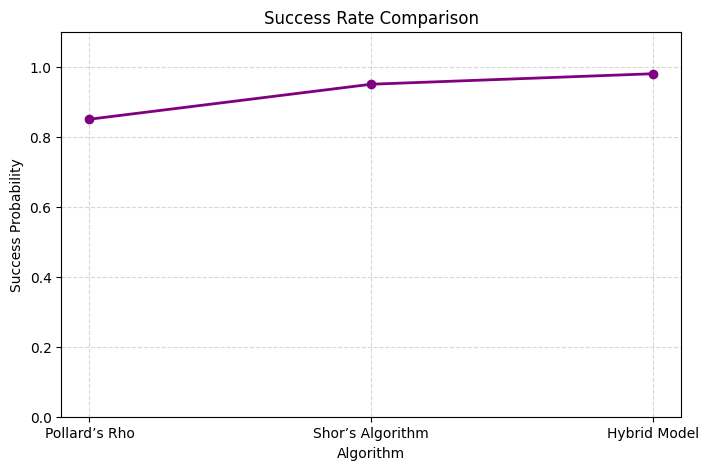

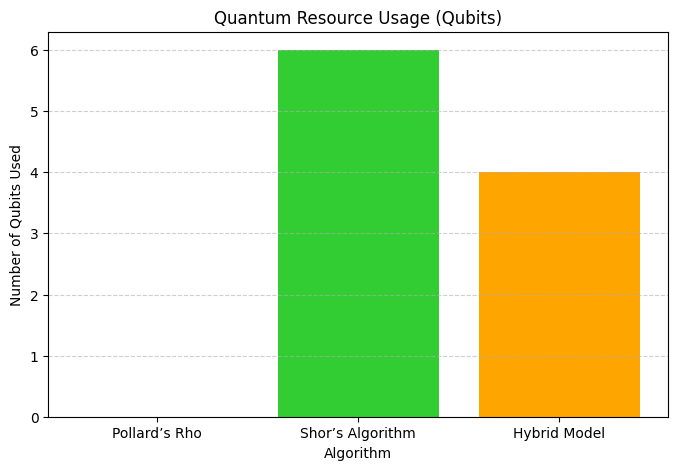

In [3]:
# --- Import Required Libraries ---
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with your actual results)
algorithms = ['Pollard’s Rho', 'Shor’s Algorithm', 'Hybrid Model']
execution_time = [2.1, 0.9, 1.3]   # in seconds
success_rate = [0.85, 0.95, 0.98]  # success probability
qubits_used = [0, 6, 4]            # number of qubits required (0 = classical)

# --- Visualization 1: Execution Time ---
plt.figure(figsize=(8,5))
plt.bar(algorithms, execution_time, color=['#6A5ACD', '#3CB371', '#FF8C00'])
plt.title('Execution Time Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Visualization 2: Success Probability ---
plt.figure(figsize=(8,5))
plt.plot(algorithms, success_rate, marker='o', linestyle='-', color='purple', linewidth=2)
plt.title('Success Rate Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Success Probability')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Visualization 3: Quantum Resource Usage ---
plt.figure(figsize=(8,5))
plt.bar(algorithms, qubits_used, color=['#4682B4', '#32CD32', '#FFA500'])
plt.title('Quantum Resource Usage (Qubits)')
plt.xlabel('Algorithm')
plt.ylabel('Number of Qubits Used')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
